## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

### Merge dataframes

In [2]:
# CheXpert+ dataset (without disease labels)
df_cxr_plus = pd.read_csv('data/df_chexpert_plus_240401.csv')

In [3]:
# Includes disease labels
csv_train='data/train.csv'
csv_valid='data/test.csv'

df_train = pd.read_csv(csv_train)
df_valid = pd.read_csv(csv_valid)

In [4]:
diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']
print(f'Number of different diseases: {len(diseases)}')

Number of different diseases: 14


In [5]:
df_train['path_to_image'] = df_train.Path.apply(lambda x: '/'.join(x.split('/')[1:]))
df_valid['path_to_image'] = df_valid.Path.apply(lambda x: '/'.join(x.split('/')[1:]))

df_combined = pd.concat([df_train, df_valid], axis=0)
df_merged = df_cxr_plus.merge(df_combined[['path_to_image'] + diseases], on='path_to_image', how='left')

print(f'Train: {len(df_train)} samples')
print(f'Valid: {len(df_valid)} samples')
print(f'Train and Valid: {len(df_combined)} samples')
print(f'Original CXR+: {len(df_cxr_plus)} samples')
print(f'Merged: {len(df_merged)} samples')

Train: 223414 samples
Valid: 234 samples
Train and Valid: 223648 samples
Original CXR+: 223462 samples
Merged: 223462 samples


# Remove lateral studies

In [6]:
# get all rows that contain "lateral" in path_to_image
lateral = df_merged[df_merged['path_to_image'].str.contains('lateral')]
print(f'Number of lateral images: {len(lateral)}')
frontal = df_merged[df_merged['path_to_image'].str.contains('frontal')]
print(f'Number of frontal images: {len(frontal)}')

removed_by_lateral = len(lateral)

# remove all rows that contain "lateral" in path_to_image
df_merged = df_merged[~df_merged['path_to_image'].str.contains('lateral')]
print(f'Number of samples after removing lateral images: {len(df_merged)}')


Number of lateral images: 32391
Number of frontal images: 191071
Number of samples after removing lateral images: 191071


## Disease Labels

No Finding: No Finding
NaN    173910
1.0     16985
0.0       176
Name: count, dtype: int64
Enlarged Cardiomediastinum: Enlarged Cardiomediastinum
 NaN    156083
 0.0     15428
-1.0     10280
 1.0      9280
Name: count, dtype: int64
Cardiomegaly: Cardiomegaly
 NaN    152934
 1.0     23433
 0.0      8001
-1.0      6703
Name: count, dtype: int64
Lung Opacity: Lung Opacity
 1.0    94253
 NaN    87262
 0.0     5131
-1.0     4425
Name: count, dtype: int64
Lung Lesion: Lung Lesion
 NaN    181949
 1.0      7038
-1.0      1107
 0.0       977
Name: count, dtype: int64
Edema: Edema
 NaN    113524
 1.0     49672
 0.0     16065
-1.0     11810
Name: count, dtype: int64
Consolidation: Consolidation
 NaN    133947
-1.0     24353
 0.0     19765
 1.0     13006
Name: count, dtype: int64
Pneumonia: Pneumonia
 NaN    168350
-1.0     15972
 1.0      4680
 0.0      2069
Name: count, dtype: int64
Atelectasis: Atelectasis
 NaN    130326
-1.0     29823
 1.0     29772
 0.0      1150
Name: count, dtype: int64
Pne

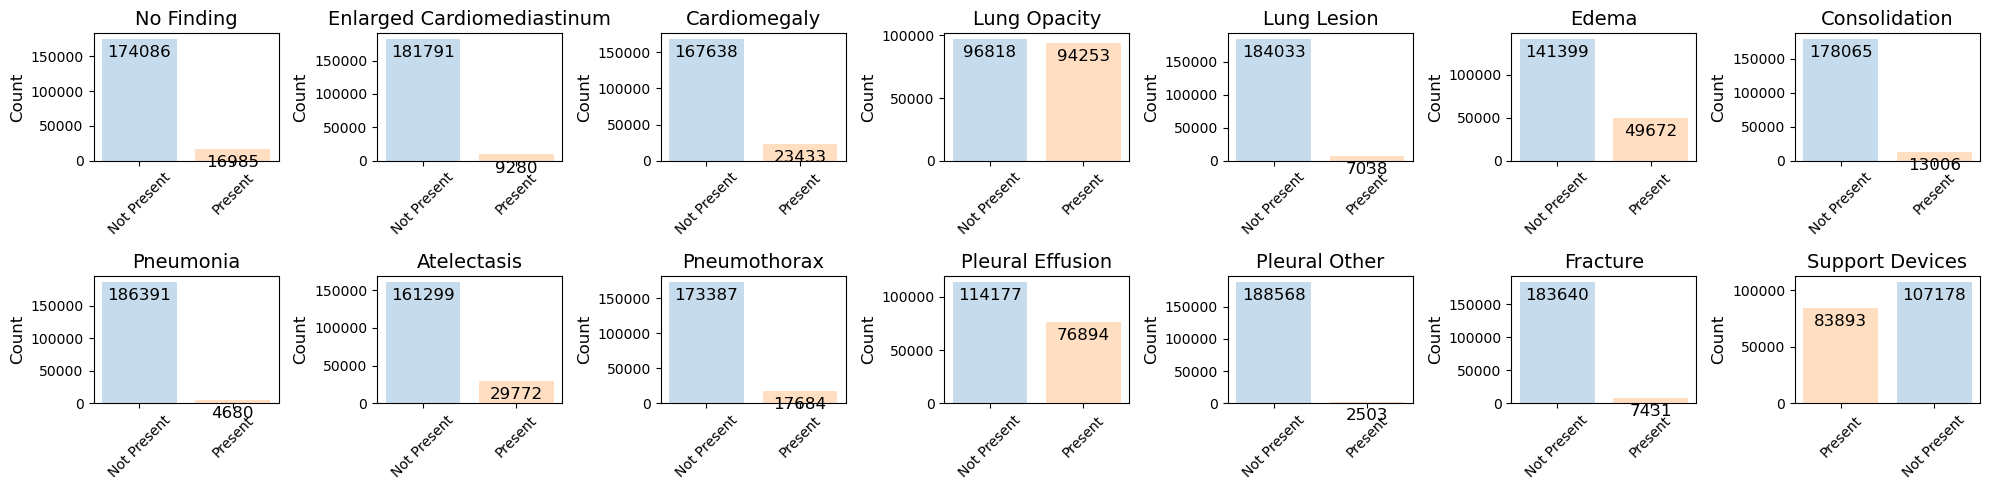

In [7]:
# value count for each disease
for disease in diseases:
    print(f'{disease}: {df_merged[disease].value_counts(dropna=False)}')

# rename values of disease -1 to 0 and nan to 0
for disease in diseases:
    df_merged[disease] = df_merged[disease].replace(-1, 0)
    df_merged[disease] = df_merged[disease].fillna(0)
    df_merged[disease] = df_merged[disease].astype(int)

# Create a subplot which shows the count of each disease
fig, ax = plt.subplots(2, 7, figsize=(20, 5))

# Iterate over each disease
for i, disease in enumerate(diseases):
    # Count the occurrences of each label
    counts = df_merged[disease].value_counts()
    colors = get_colors(2)
    # Plot bar graph for better visual representation
    bars = ax[i // 7, i % 7].bar(counts.index, counts.values, color=colors)
    
    # Set the title and labels
    ax[i // 7, i % 7].set_title(disease, fontsize=14)
    ax[i // 7, i % 7].set_xticks(counts.index)  # Ensure x-ticks match labels
    ax[i // 7, i % 7].set_xticklabels(['Not Present', 'Present'], rotation=45)
    ax[i // 7, i % 7].set_ylabel('Count', fontsize=12)

    # Add count values inside the bars
    for bar in bars:
        yval = bar.get_height()
        ax[i // 7, i % 7].text(bar.get_x() + bar.get_width() / 2, 
                                yval - (0.05 * max(counts.values)),  # Adjust the height to position inside
                                int(yval), 
                                ha='center', 
                                va='top',  # Align text to the top of the adjusted height
                                fontsize=12,
                                color='black')  

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Clean biased variables

In [8]:
biased_columns = ["sex", "age", "race", "health_insurance"]
data_columns = ["path_to_image", "path_to_dcm"]

### sex

In [9]:
df_cleaned_sex = df_merged.copy()
print(f'Number of samples before cleaning: {len(df_cleaned_sex)}')

Number of samples before cleaning: 191071


In [10]:
col = "sex"
df_merged[col].value_counts(dropna=False)

sex
Male       112034
Female      78819
Unknown       218
Name: count, dtype: int64

In [11]:
df_cleaned_sex = df_cleaned_sex[df_cleaned_sex[col] != 'Unknown']
removed_by_sex = len(df_merged) - len(df_cleaned_sex)
print(f' Removed samples with sex = Unknown: {removed_by_sex}')

 Removed samples with sex = Unknown: 218


### race

In [12]:
df_cleaned_race = df_merged.copy()
print(f'Number of samples before cleaning: {len(df_cleaned_race)}')

Number of samples before cleaning: 191071


In [13]:
col = "race"
df_merged[col].value_counts(dropna=False)

race
White               108502
Other                26358
Unknown              22786
Asian                20012
Black                10144
Pacific Islander      2499
Native American        469
Patient Refused        301
Name: count, dtype: int64

In [14]:
df_cleaned_race = df_cleaned_race[df_cleaned_race[col].isin(['White', 'Asian', 'Black'])]
removed_by_race = len(df_merged) - len(df_cleaned_race)
print(f' Removed samples if race not in [White, Asian, Black]: {removed_by_race}')

 Removed samples if race not in [White, Asian, Black]: 52413


### health insurance

In [15]:
df_cleaned_health_insurance = df_merged.copy()
print(f'Number of samples before cleaning: {len(df_cleaned_health_insurance)}')

Number of samples before cleaning: 191071


In [16]:
col = "insurance_type"
df_merged[col].value_counts(dropna=False)

insurance_type
Medicare             91316
Private Insurance    40881
Unknown              36758
Medicaid             18259
Other                 3857
Name: count, dtype: int64

In [17]:
df_cleaned_health_insurance = df_cleaned_health_insurance[df_cleaned_health_insurance[col].isin(['Medicare', 'Private Insurance', 'Medicaid'])]
removed_by_insurance = len(df_merged) - len(df_cleaned_health_insurance)
print(f' Removed samples if insurance_type not in [Medicare, Private Insurance, Medicaid]: {removed_by_insurance}')

 Removed samples if insurance_type not in [Medicare, Private Insurance, Medicaid]: 40615


### age

In [18]:
df_cleaned_age = df_merged.copy()
print(f'Number of samples before cleaning: {len(df_cleaned_age)}')

Number of samples before cleaning: 191071


Number of nan values: 217
Mean: 60.638419944041
Median: 62.0
Min: 0.0
Max: 89.0


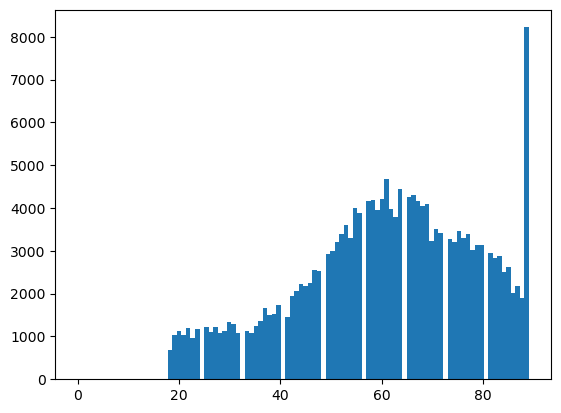

In [19]:
col = "age"
print(f'Number of nan values: {df_cleaned_age[col].isna().sum()}')

# plot distribution as histogram
plt.hist(df_cleaned_age[col], bins=100)
np.set_printoptions(suppress=True)

print(f'Mean: {df_cleaned_age[col].mean()}')
print(f'Median: {df_cleaned_age[col].median()}')
print(f'Min: {df_cleaned_age[col].min()}')
print(f'Max: {df_cleaned_age[col].max()}')

   

## Save cleaned dataframe

In [20]:
df_cleaned_sex.to_csv('processed_data/chexpert_plus_240401_cleaned_sex.csv', index=False)
df_cleaned_race.to_csv('processed_data/chexpert_plus_240401_cleaned_race.csv', index=False)
df_cleaned_health_insurance.to_csv('processed_data/chexpert_plus_240401_cleaned_health_insurance.csv', index=False)
df_cleaned_age.to_csv('processed_data/chexpert_plus_240401_cleaned_age.csv', index=False)


# Overview Removed data 

### Removed by biased value

In [21]:
print(f'Number of samples after removing lateral studies: {len(df_merged)}')
print(f'Number of samples after cleaning sex: {len(df_cleaned_sex)}')
print(f'Number of samples after cleaning race: {len(df_cleaned_race)}')
print(f'Number of samples after cleaning insurance: {len(df_cleaned_health_insurance)}')
print(f'Number of samples after cleaning age: {len(df_cleaned_age)}')


Number of samples after removing lateral studies: 191071
Number of samples after cleaning sex: 190853
Number of samples after cleaning race: 138658
Number of samples after cleaning insurance: 150456
Number of samples after cleaning age: 191071
